# TAIL RISK FUND: OPTIONS (BHANSALI STRATEGY)

author: [@sparshsah](https://github.com/sparshsah)

ref: https://github.com/sparshsah/foggy-demo/blob/main/demo/finance/tail-risk-fund_options.ipynb

In [16]:
from __future__ import annotations

import dataclasses
import datetime
from typing import Final, Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# https://github.com/sparshsah/foggy-statslib
import sys; sys.path.append("../../../foggy-statslib/")
import foggy_statslib.core as fsc
import foggy_statslib.fin as fsf

In [92]:
BUDGET_DOL: Final[float] = 100
START_DATE: Final[datetime.datetime] = datetime.datetime(2014, 7, 1)
ROLL_BUFFER_DAYS: Final[int] = 5  # look to roll this many trading days before expiration
IMPL_LAG_DAYS: Final[int] = 3  # trading lag in days


@dataclasses.dataclass(kw_only=True, frozen=True)
class StrategyConfig:
    """By default, buy COF puts quarterly at 20% OTM, selling iff value hits 2x initial price."""
    underlying_ticker: str = "COF"
    period_freq: Literal["M", "Q", "2Q", "Y"] = "Q"
    strike_otm_px: float = 0.20
    sell_thresh: float = 2.0

    @property
    def periods(self) -> pd.PeriodIndex:
        return pd.period_range(
            start=START_DATE,
            end=datetime.datetime.now(),
            freq=self.period_freq,
            name="period",
        # first period is burn-in
        )[1:]

    @property
    def timeseries(self) -> pd.DataFrame:
        ts = pd.DataFrame(index=self.periods)
        ts.loc[:, "entry_date"] = ts.index.start_time - ROLL_BUFFER_DAYS * pd.offsets.BDay()
        ts.loc[:, "expiration_date"] = ts.index.end_time
        return ts


class MarketDataAccess:
    """Module for getting data."""

    @staticmethod
    def get_stock_history(ticker: str = "COF") -> pd.DataFrame:
        p = (
            pd.read_csv(
                f"data/yahoo-finance_NYSE-{ticker}_px.csv",
                index_col="Date",
                parse_dates=True,
            )
            .loc[START_DATE:, "Close"]
            .rename_axis("date").rename("unadj_close_price_dol")
            .asfreq("D").ffill()
        )
        p_b = p.asfreq("B")
        r_b = p_b / p_b.shift() - 1
        vol_b = _calc_vol(r=r_b)
        vol = vol_b.asfreq("D").ffill()
        history = pd.concat([p, vol], axis="columns", verify_integrity=True)
        return history


# HELPERS


def _calc_vol(r: pd.Series[float], freq: str = "B") -> pd.Series[float]:
    """Hackily calculate realized vol from returns."""
    if r.index.freq != "B":
        raise ValueError(freq)
    return (
        (
            r
            # assert that ER_daily is close to zero
            .abs()
            # hackily remove influence of stock splits
            .clip(upper=0.20)
            **2
        )
        # a business quarter
        .rolling(window=65)
        .mean()
        **0.5
        # annualize
        * 261**0.5
    ).rename("vol")

In [ ]:
def _generate_put_histories() -> pd.DataFrame:
    """Lacking Polygon.io access, manually generate just the data points we need using Black-Scholes."""
    cfg = StrategyConfig()
    ts = cfg.timeseries
    sh = MarketDataAccess.get_stock_history(ticker=cfg.underlying_ticker)
    ts.loc[:, "strike_price_dol"] = ts["entry_date"].map(
        hs["unadj_close_price_dol"] *
    )

    def _gen_cell(period: pd.Period, t: pd.Timestamp) -> float:
        entry_date = ts.loc[period, "entry_date"]
        if t < entry_date:
            return np.nan
        expiration_date = ts.loc[period, "expiration_date"]
        if t > expiration_date:
            return np.nan
        tau = (expiration_date - t).days / 365
        strike_price_dol = sh.loc[entry_date, "unadj_close_price_dol"] * (1 - cfg.strike_otm_px)

    hp = pd.DataFrame(
        columns=ts.index,
        index=pd.date_range(start=START_DATE, end=datetime.datetime.now(), freq="D"),
        dtype=float,
    )
    for contract_ticker in hp.columns:
        for t in hp.index:
            hp.loc[t, contract_ticker] = fsf.calc_bsf_option_value(
                tau=

In [89]:
fsf.calc_bsf_option_value?

Signature:
fsf.calc_bsf_option_value(
    tau: 'float' = 1,
    K: 'float' = 100,
    S_t: 'float' = 100,
    sigma: 'float' = 0.2,
    r: 'float' = 0,
    put: 'bool' = True,
) -> 'float'
Docstring:
Calculate Black-Scholes formula for option value.
Note: Applies to European-style options only!

Args:
    tau: float, Years to expiration.
    K: float, Strike price.
    S_t: float, Price of underlying stock today.
    sigma: float, Assumed volatility. Logarithmic, to be geeky about it.
        Note: Be careful! Black-Scholes is a very good baseline model for how people value options in real life.
            But in real life, `sigma` is usually a bit higher than
            a true best guess for go-forward volatility (based on e.g. recent realized volatility).
                This is the well-documented "volatility risk premium".
                The usual explanation is the overwhelming pressure of demand for insurance against economic crashes.
            And in fact, it's usually a bi

In [87]:
cfg = StrategyConfig()
cfg.timeseries.head()

,entry_date,expiration_date
period,,
2014Q4,2014-09-24,2014-12-31 23:59:59.999999999
2015Q1,2014-12-25,2015-03-31 23:59:59.999999999
2015Q2,2015-03-25,2015-06-30 23:59:59.999999999
2015Q3,2015-06-24,2015-09-30 23:59:59.999999999
2015Q4,2015-09-24,2015-12-31 23:59:59.999999999


In [88]:
hs = MarketDataAccess.get_history_for_stock()
hs.head()

,price_close_unadj,vol
date,,
2014-07-01,83.019997,NaN
2014-07-02,83.599998,NaN
2014-07-03,84.949997,NaN
2014-07-04,84.949997,NaN
2014-07-05,84.949997,NaN


<Axes: xlabel='date'>

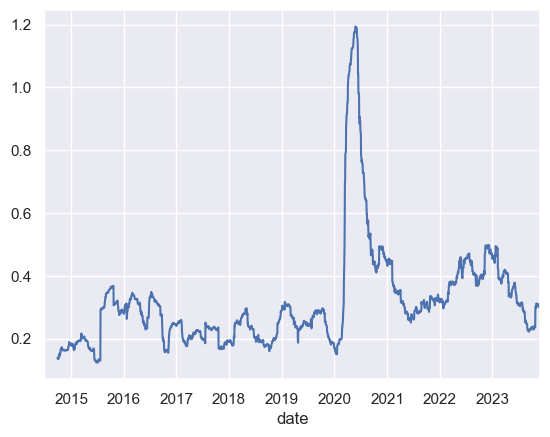

In [46]:
x["vol"].plot()